### **Connect with google drive**

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Check Gpu In Google Colab**
it recommended to use Gpu for accelerate learning.

In [4]:
!nvidia-smi -L


NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [5]:
import tensorflow as tf
tf.test.gpu_device_name()

''

###**import library**

In [1]:
# !pip install tensorflow-data-validation

In [ ]:
#kill current process for restart runtime
import os
os.kill(os.getpid(), 9)

In [3]:
import os
import cv2
import pandas as pd
import math
import random as rd
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import Video,Audio
import librosa
import librosa.display
import soundfile as sf
import pickle
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import dlib

%matplotlib inline
 
from sklearn.model_selection import train_test_split
import tensorflow_data_validation as tfdv
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [8]:
seed_constant = 27
np.random.seed(seed_constant)
rd.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [4]:
DIR='/content/drive/MyDrive/'

### **Dowmload dataset RAVDESS**

In [4]:
actor=[('0'+str(x)) if x<=9 else str(x)  for x in range(1,25) ]
print(actor)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']


In [6]:
data_folder = '/ravdess_VIDEO/'
link='https://zenodo.org/record/1188976/files/Video_Speech_Actor_'
indice_='.zip?download=1'
if not os.path.exists(os.path.abspath(DIR) + data_folder):
  for i in actor:
    annotation_zip = tf.keras.utils.get_file('captions.zip',
                                            cache_subdir=os.path.abspath(DIR) + data_folder,
                                            origin=link+i+indice_,
                                            extract=True)
    os.remove(annotation_zip)


In [7]:
data_folder_audio = '/ravdess_audio/'
link_audio='https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip?download=1'
if not os.path.exists(os.path.abspath(DIR) + data_folder_audio):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath(DIR) + data_folder_audio,
                                          origin=link_audio,
                                          extract=True)
  os.remove(annotation_zip)


In [5]:
audio_folder=os.path.abspath(DIR) + '/ravdess_audio/'
video_folder=os.path.abspath(DIR) + '/ravdess_VIDEO/'
print(os.path.exists(audio_folder))
print(os.path.exists(video_folder))

True
True


In [9]:
## if getdata file no exist use thsi code
# %%writefile getdata.py
# from collections import defaultdict
# import os
# import pandas as pd

# classes_list = [
#   ['full-AV', 'video-only','audio-only'],
#   ['speech', 'song'],
#   ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'],
#   ['normal', 'strong'],
#   ["Kids are talking by the door", "Dogs are sitting by the door"],
#   ['1st repetition', '2nd repetition'],
#   ["male", "female"],
# ]
# def getListOfFiles(dirName):
#     listOfFile = os.listdir(dirName)
#     allFiles = defaultdict(list)
#     for entry in listOfFile:
#         file = os.listdir(dirName+'/'+entry)
#         allFiles[entry]=file
                
#     return allFiles
# def load_RAVDESinfo(data_dir, list_classes, X=None, Y=None):
#   """
#   this function will return audio file PATH and labels seperately when data directory(`data_dir`) 
#   and the class list(list_classes) are passed to it
#   """
#   audio_dataset = list()

#   if not(X or Y):
#     X = list()
#     Y = list()
#   actors = [dir for dir in os.listdir(data_dir) if dir.startswith('Actor_')]
#   for dir in actors:
#     act_dir = os.path.join(data_dir,dir)
#     for wav in os.listdir(act_dir):
#       # getting labels form the encoded file names
#       label = [(int(i)-1) for i in wav.split('.')[0].split('-')]
#       # converting gender labels to only 0 and 1
#       label[-1] = 1 if label[-1]%2 else 0

#       l_text = []

#       # converting labels back to string
#       for i in range(0, len(label)):
#         l_text.append(list_classes[i][label[i]])
        

#       X.append(os.path.join(act_dir, wav)) 
#       Y.append(l_text)
  
#   return X,Y
# def getdata(video_folder:str):
#   video_info=load_RAVDESinfo(video_folder,classes_list)
#   label_headers = ['Audio_file', 'modality', 'vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'gender']
#   df_=defaultdict(list)
#   df_[label_headers[0]]=video_info[0]
#   for j,label in enumerate(label_headers[1:],0):
#     df_[label]=[i[j] for i in video_info[1]]

#   return pd.DataFrame(df_) 

In [10]:
# !mv getdata.py {DIR}/recognition_of_emotions_from_videos

In [6]:
getdf=f'{DIR}/recognition_of_emotions_from_videos'

In [7]:
import sys
sys.path.append(getdf)

In [8]:
import getdata 
df_video=getdata.getdata(video_folder)
df_video.head()

,Audio_file,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,gender
0,/content/drive/MyDrive/ravdess_VIDEO/Actor_01/...,full-AV,speech,neutral,normal,Kids are talking by the door,1st repetition,male
1,/content/drive/MyDrive/ravdess_VIDEO/Actor_01/...,full-AV,speech,neutral,normal,Kids are talking by the door,2nd repetition,male
2,/content/drive/MyDrive/ravdess_VIDEO/Actor_01/...,full-AV,speech,neutral,normal,Dogs are sitting by the door,1st repetition,male
3,/content/drive/MyDrive/ravdess_VIDEO/Actor_01/...,full-AV,speech,neutral,normal,Dogs are sitting by the door,2nd repetition,male
4,/content/drive/MyDrive/ravdess_VIDEO/Actor_01/...,full-AV,speech,calm,normal,Kids are talking by the door,1st repetition,male


In [9]:
df_video_only=df_video[df_video.modality=='video-only']

# **Preprocessing and prepare dataset**

### **optional for visualization des properties the videos**

In [13]:
!pip install get-video-properties

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 45.1 MB 2.9 MB/s 


In [14]:
from videoprops import get_video_properties

def video_properties(lien:str) ->  dict:
  props = get_video_properties(lien)
  props_=dict()
  info=['codec_name','width','height','avg_frame_rate','display_aspect_ratio','nb_frames']
  for i in info:
    if i in ['width','height','nb_frames']:
      props_[i]=int(props[i])
    else:
      props_[i]=props[i]
  props_['duration']=float(props['duration'])
  props_['fps']=int(int(props['nb_frames'])//float(props['duration']))
  props_['dir']=lien
  
  return props_



In [15]:
video_properties('/content/drive/MyDrive/ravdess_VIDEO/Actor_01/02-01-01-01-01-02-01.mp4')

{'codec_name': 'h264',
 'width': 1280,
 'height': 720,
 'avg_frame_rate': '30000/1001',
 'display_aspect_ratio': '16:9',
 'nb_frames': 100,
 'duration': 3.336667,
 'fps': 29,
 'dir': '/content/drive/MyDrive/ravdess_VIDEO/Actor_01/02-01-01-01-01-02-01.mp4'}

In [19]:
f=list(df_video_only.Audio_file)

In [20]:
df_video_properties=map(video_properties,f[:1440])

In [21]:
df_video_properties=list(df_video_properties)

In [22]:
df=pd.DataFrame(df_video_properties)
df.head()

,codec_name,width,height,avg_frame_rate,display_aspect_ratio,nb_frames,duration,fps,dir
0,h264,1280,720,30000/1001,16:9,99,3.303300,29,/content/drive/MyDrive/ravdess_VIDEO/Actor_01/...
1,h264,1280,720,30000/1001,16:9,100,3.336667,29,/content/drive/MyDrive/ravdess_VIDEO/Actor_01/...
2,h264,1280,720,30000/1001,16:9,99,3.303300,29,/content/drive/MyDrive/ravdess_VIDEO/Actor_01/...
3,h264,1280,720,30000/1001,16:9,95,3.169833,29,/content/drive/MyDrive/ravdess_VIDEO/Actor_01/...
4,h264,1280,720,30000/1001,16:9,106,3.536867,29,/content/drive/MyDrive/ravdess_VIDEO/Actor_01/...


In [23]:
df.insert(1,"emotion",list(df_video_only.emotion))

In [24]:
stats_options = tfdv.StatsOptions(feature_allowlist=list(df.columns))

In [25]:
stats_training=tfdv.generate_statistics_from_dataframe(df,stats_options)

In [26]:
tfdv.visualize_statistics(stats_training)

### **for the videos (sequence of frame)**

In [10]:
from IPython.display import HTML
from base64 import b64encode
 
def show_video(video_path, video_width = 300):
   
  video_file = open(video_path, "rb").read()
 
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

In [11]:
videos_path=list(df_video_only.Audio_file)

In [12]:
# Video(rd.sample(videos_path,1)[0],embed=True,width=300,height=300)
show_video(rd.sample(videos_path,1)[0])

Output hidden; open in https://colab.research.google.com to view.

In [27]:
SEQUENCE_LENGTH=20
(IMAGE_HEIGHT, IMAGE_WIDTH)=20,20

In [28]:
detector = dlib.get_frontal_face_detector()

def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after detect face and resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video (faces).
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)
 
    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
 
    # Iterate through the Video Frames.
    # for frame_counter in tqdm_notebook(range(SEQUENCE_LENGTH)):
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        # Reading the frame from the video. 
        success, frame = video_reader.read() 
        # Check if Video frame is not successfully read then break the loop
        if not success:
            break
 
        # detect and crop face in frame.
        faces = detector(frame, 0) 
        crop_img = frame[faces[0].top():faces[0].bottom(),faces[0].left():faces[0].right()]
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(crop_img, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        resized_frame=cv2.cvtColor(resized_frame, cv2.COLOR_RGB2GRAY)
        
        # Append the normalized frame into the frames list
        frames_list.append(resized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Return the frames list.
    return frames_list

In [29]:
frames=frames_extraction(rd.sample(videos_path,1)[0])

In [30]:
import time,sys
start = time.time()
t=frames_extraction('/content/drive/MyDrive/ravdess_VIDEO/Actor_03/01-01-01-01-01-01-03.mp4')
end = time.time()
print("The time of execution of above program is :", end-start)


The time of execution of above program is : 6.042256832122803


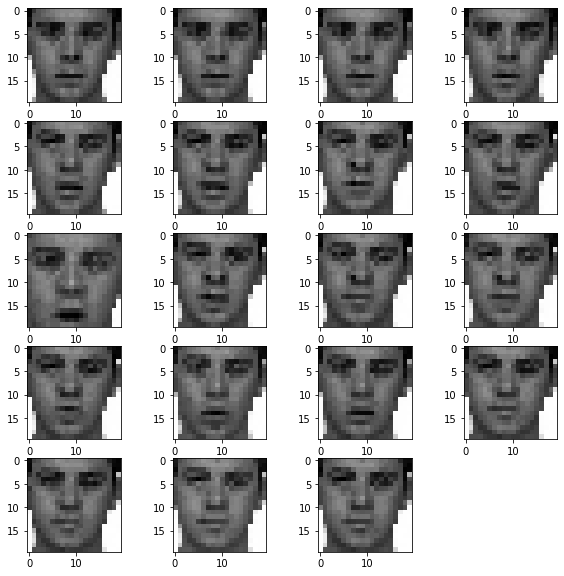

In [35]:
plt.figure(figsize = (10, 10))
for i in range(1,SEQUENCE_LENGTH):
  plt.subplot(5,4,i)
  plt.imshow(t[i],cmap='gray')

In [45]:
emotions_en=df_video_only.emotion.unique()

In [32]:
def create_dataset():

    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''
 
    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(tqdm_notebook(emotions_en)):
            
            # Display the name of the class whose data is being extracted.
            print(f'Extracting Data of Class: {class_name}')
            
            # Get the list of video files present in the specific class name directory.
            files_list = list(df_video_only.Audio_file[df_video_only.emotion == class_name])
            
            # Iterate through all the files present in the files list.
            for video_file_path in files_list:
                
    
                # Extract the frames of the video file.
                frames = frames_extraction(video_file_path)
    
                # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
                # So ignore the vides having frames less than the SEQUENCE_LENGTH.
                if len(frames) == SEQUENCE_LENGTH:
    
                    # Append the data to their repective lists.
                    features.append(frames)
                    labels.append(class_index)
                    video_files_paths.append(video_file_path)
    
        # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
        
        # Return the frames, class index, and video file path.
    return {'features':features, 'labels':labels, 'video_files_paths':video_files_paths}

In [39]:
df=create_dataset()

In [ ]:
datafile = open('data', 'ab')
pickle.dump(df, datafile)                     
datafile.close()

### **for the audio**

for extract feature in video ,there are two technique extarct 1-Dimension features or 2D.
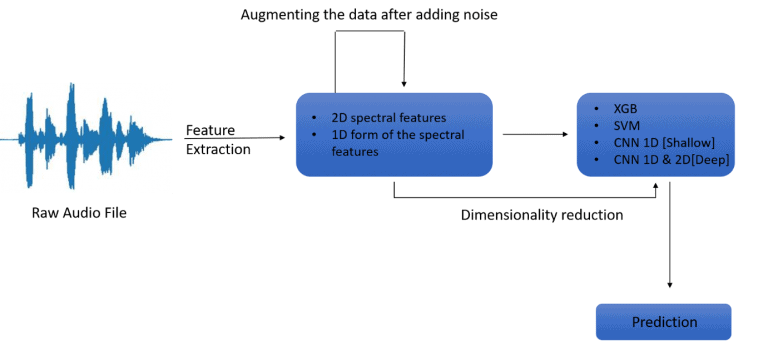

In [33]:
df_audio=getdata.getdata(audio_folder)
df_audio.head()

,Audio_file,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,gender
0,/content/drive/MyDrive/ravdess_audio/Actor_01/...,audio-only,speech,neutral,normal,Kids are talking by the door,1st repetition,male
1,/content/drive/MyDrive/ravdess_audio/Actor_01/...,audio-only,speech,neutral,normal,Kids are talking by the door,2nd repetition,male
2,/content/drive/MyDrive/ravdess_audio/Actor_01/...,audio-only,speech,neutral,normal,Dogs are sitting by the door,1st repetition,male
3,/content/drive/MyDrive/ravdess_audio/Actor_01/...,audio-only,speech,neutral,normal,Dogs are sitting by the door,2nd repetition,male
4,/content/drive/MyDrive/ravdess_audio/Actor_01/...,audio-only,speech,calm,normal,Kids are talking by the door,1st repetition,male


#### **For 1-D**

In [19]:
import torchaudio

def check_channel(Dataframe):
  """
  this function will take a dataframe as input and loop throught it searching for multichannel audio, 
  if found it will print the shape as a Tensor and its index in the dataframe
  """
  for i,audio_file in enumerate(Dataframe["Audio_file"]):
#     fname = os.path.join(data_dir, audio_file)
    data, rate = torchaudio.load(audio_file)
    data_shape = list(data.shape)

    if data_shape[0] != 1:
      print(f"index: {i}, shape : {data.shape}")

In [21]:
# check_channel(df_audio)


In [22]:
x, sr = librosa.load(df_audio.Audio_file[5])
Audio(data=x, rate=sr)

In [24]:
x, sr =librosa.load(df_audio.Audio_file[5], duration=2.5, offset=0.6)
Audio(data=x, rate=sr)

In [25]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [26]:
def extract_features(data,sample_rate):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data,sample_rate)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data,sample_rate)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch,sample_rate)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [40]:
emotions = []
features=[]
audio_path = []
for class_index, class_name in enumerate(emotions_en):
            
            # Display the name of the class whose data is being extracted.
            print(f'Extracting Data of Class: {class_name}')
            
            # Get the list of video files present in the specific class name directory.
            files_list = list(df_audio.Audio_file[df_audio.emotion == class_name])
            
            # Iterate through all the files present in the files list.
            for video_file_path in files_list:
              emotions.append(class_index)
              features.append(get_features(video_file_path))
              audio_path.append(video_file_path)

Extracting Data of Class: neutral


KeyboardInterrupt: ignored

In [ ]:
df_={'features':features, 'labels':emotions, 'audio_files_paths':audio_path}
datafile = open('data_audio_1D', 'ab')
pickle.dump(df_, datafile)                     
datafile.close()

#### **For 2-D**

In [35]:
def load_spec(audio_path, mode=0):

  wave, sr = librosa.load(audio_path,sr=None,mono=True)

  s, _ = librosa.effects.trim(wave,top_db=60)
  
    
  # generate (mel)spectrogram / mfcc
  if(mode == 1):
    s = librosa.feature.melspectrogram(y=s, sr=sr, hop_length=512)
  elif(mode == 2):

    s = librosa.feature.mfcc(y=s, sr=sr, n_mfcc=40)
  else:
    freqs, times, s = librosa.reassigned_spectrogram(y=s, sr=sr, hop_length=512)
    
  return s,sr

In [41]:
y, sr = load_spec(df_audio.Audio_file[8],1)

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

fig = plt.Figure()
canvas = FigureCanvas(fig)
ax = fig.add_subplot(111)
ax.set_axis_off
p = librosa.display.specshow(librosa.power_to_db(y), ax=ax)
fig.savefig('spec.png',bbox_inches='tight',pad_inches=0.0)

In [37]:
cv2.imread('spec.png').shape

(220, 338, 3)

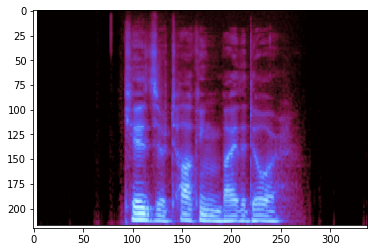

In [42]:
plt.imshow(cv2.imread('spec.png'))

In [43]:
df_audio.Audio_file[8].split('/')[-1].split('.')[0]

'03-01-02-02-01-01-01'

In [44]:
labels = []
path_mels = []
folder='/content/drive/MyDrive/ravdess_melspec/'
for class_index, class_name in enumerate(emotions_en):
            
            # Display the name of the class whose data is being extracted.
            print(f'Extracting Data of Class: {class_name}')
            
            # Get the list of video files present in the specific class name directory.
            files_list = list(df_audio.Audio_file[df_audio.emotion == class_name])
            
            # Iterate through all the files present in the files list.
            for video_file_path in files_list:
              y, sr = load_spec(video_file_path,1)
              fig = plt.Figure()
              canvas = FigureCanvas(fig)
              ax = fig.add_subplot(111)
              ax.set_axis_off()
              p = librosa.display.specshow(librosa.power_to_db(y), ax=ax)
              path=video_file_path.split('/')[-1].split('.')[0]
              fig.savefig(folder+path+'.png',bbox_inches='tight',pad_inches=0.0)
              labels.append(class_index)
              path_mels.append(folder+path+'.png')

NameError: ignored

In [ ]:
import glob
path_mels=glob.glob(folder+"*.png")

In [ ]:
df=np.ones((1440,224, 224, 3),dtype='uint8')
for i in range(1440):
  img=cv2.imread(path_mels[i])
  img=cv2.resize(img,(224, 224))
  df[i]=img

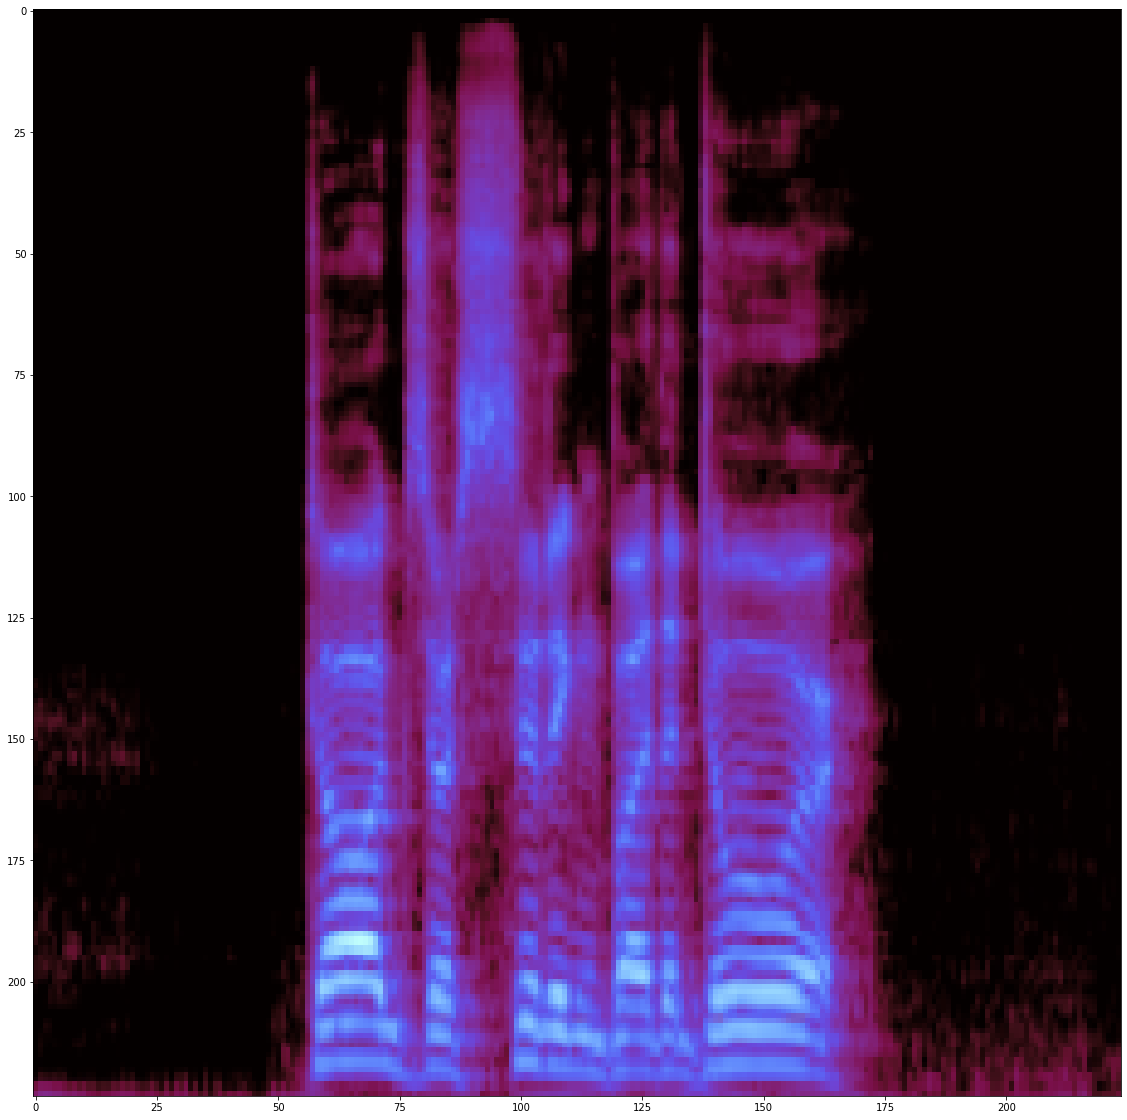

In [ ]:
plt.figure(figsize = (10, 10))
plt.imshow(df[590])